In [1]:
!pip install onnx
!pip install onnxruntime
!pip install onnx2pytorch
!pip install maraboupy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00


In [ ]:
# data=iris.data
# data
# X_train
#labels=iris.target #target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10' - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# # Define the neural network architecture
# class IrisNet(nn.Module):
#     def __init__(self):
#         super(IrisNet, self).__init__()
#         self.fc1 = nn.Linear(4, 10)  # Input layer to hidden layer
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(10, 10) # Hidden layer to hidden layer
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(10, 3)  # Hidden layer to output layer

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         return x

# # Initialize the network
# model = IrisNet()

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# epochs = 100
# for epoch in range(epochs):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Print loss every 10 epochs
#     if epoch % 10 == 9:
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Check if the model trains without error up to this point
# "Model trained successfully!"


In [3]:
import onnx
from onnx2pytorch import ConvertModel


onnx_model = onnx.load("iris_model.onnx")
model = ConvertModel(onnx_model)

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

i=1
# Assuming the ReLU layers are named similarly to your PyTorch model, you can add hooks like this
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        # Register the hook
        layer.register_forward_hook(get_activation(f'relu{i}'))
        i=i+1

# Now, when you run a forward pass, the hooks will store the ReLU activations
with torch.no_grad():
    output = model(X_train_tensor[0].unsqueeze(0))

# Check the captured activations
activations
# Remove hooks (to clean up)
# hook1.remove()
# hook2.remove()

/usr/local/lib/python3.10/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


{'relu1': tensor([[0.0000, 0.0000, 0.4279, 0.8322, 0.0000, 2.8226, 0.0000, 2.9351, 0.0000,
          0.0000]]),
 'relu2': tensor([[0.0000, 2.6728, 0.0000, 0.0000, 4.4901, 0.0000, 3.7417, 3.7264, 0.4441,
          0.0000]])}

In [4]:
#accuracy:
i=0
with torch.no_grad():
  for inputs,label in zip(X_test_tensor, y_test_tensor):
          outputs = model(inputs.unsqueeze(0))
          #print(outputs)
          pred=outputs.argmax() #output not normalized
          if pred==label:
            i=i+1
print(f'{i}/{len(X_test_tensor)}')
#model(X_train_tensor[0].unsqueeze(0))

# onnx_file_path = "iris_model.onnx"
# torch.onnx.export(model, torch.randn(1, 4), onnx_file_path, verbose=False)

30/30


find states:

In [ ]:
# states={}
# for i in range(3):
#   states[i]={}

# with torch.no_grad():
#   for neuron in range(20):
#     for idx, (inputs, labels) in enumerate(train_loader):
#       for i,t in zip(inputs,labels):
#         t=t.item()
#         outputs = model(i.unsqueeze(0))
#         out=activations[f'relu{(neuron//10)+1}'][:,neuron%10].tolist()[0]
#         if not neuron in states[t]:
#           states[t][neuron]=[]
#         states[t][neuron].append(out)

# with open("relu_states", "w") as fp:
#   json.dump(states, fp)
#states
# json
# label:{{neuron: states}, }

initialize marabou

In [5]:
from maraboupy import Marabou, MarabouCore, MarabouUtils
import json
from typing import Tuple, List
import logging
import pandas

def init_network():
  network_path = 'iris_model.onnx'
  network = Marabou.read_onnx(network_path)
  return network

with open("relu_states", "r") as fp:
    states = json.load(fp)


EPSILON = 0.5
PATTERN_PATH = 'relu_states'
MAX_TIME = 300 #in seconds
M_OPTIONS: MarabouCore.Options = Marabou.createOptions(verbosity=0, numWorkers=10, timeoutInSeconds=MAX_TIME)

def convert_keys_to_int(x):
    if isinstance(x, dict):
        return {int(k) if k.isdigit() else k: convert_keys_to_int(v) for k, v in x.items()}
    return x

with open(PATTERN_PATH, "r") as f:
  STABLE_PATTERNS = json.load(f)
  STABLE_PATTERNS=convert_keys_to_int(STABLE_PATTERNS)
loc = 0.5
radus = 0.5
non_restricted_dim = []

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
label=0
neuron=13
states#[f'{label}'][f'{neuron}']

In [ ]:
#start with all relu，删减直到不能verify？

In [6]:
network=init_network()
network.outputVars #4,5,6
network.inputVars #0,1,2,3
network.reluList #(i+10) for i in range(7,37)
network.numVars #47
offset=7

In [7]:
# for k,v in STABLE_PATTERNS[0].items():
#   print(k)
for label in STABLE_PATTERNS:
  print(label)

0
1
2


In [8]:
network.lowerBounds
exit_code, vals, stats = network.solve(options=M_OPTIONS)

ERROR


In [ ]:
network=init_network()
# for i in range(4):
#   network.setLowerBound(i, 0)
#   network.setUpperBound(i, 1)
# constraint = MarabouUtils.Equation(MarabouCore.Equation.LE)
# constraint.addAddend(1, 4)
# constraint.setScalar(0)
# network.addEquation(constraint)
#exit_code, vals, stats = network.solve(options=M_OPTIONS)

In [ ]:
def add_relu_constraints(network: Marabou.MarabouNetworkNNet, label_states)->Marabou.MarabouNetworkNNet:
    """
    Add stable relus constraints to the Marabou network
    """
    for neuron,values in label_states.items():
        layer, idx, marabou_idx = parse_raw_idx(neuron)
        print(f'{neuron}: {values}')
        if values.count(0) > len(values)*0.5: #len(X_train)*0.5:
            constraint = MarabouUtils.Equation(MarabouCore.Equation.LE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(-0.001)
        else:
            constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(0.001)
        network.addEquation(constraint)

    return network

def parse_raw_idx(raw_idx: int) -> Tuple[int, int, int]:
    n_relus = 10
    offset = 7
    layer = raw_idx // n_relus
    idx = raw_idx % n_relus
    marabou_idx = 2*n_relus*layer + idx + offset
    return layer, idx, marabou_idx


# def find_one_assignment(relu_check_list: List[int], relu_val: List[int])->None:
#     network = init_network()
#     network = add_relu_constraints(network, relu_check_list, relu_val)
#     exitCode, vals, stats = network.solve()
#     assert(exitCode=="sat")
#     for idx, r in enumerate(relu_check_list):
#         marabou_idx = parse_raw_idx(r)[-1]
# #        print(marabou_idx, vals[marabou_idx], relu_val[idx]) command + .

def check_pattern(label_states, label: int, other_label: int)->Tuple[str, int]: #relu_check_list: List[int], relu_val: List[int]
    """
    In ACAS, the prediction is the label with smallest value.
    So we check that label - other_label < 0 forall input
    by finding assignments for label - other_label >=0
    """
    print("--------CHECK PATTERN: output_{} is always less than output_{} ? --------".format(label, other_label))
    network = init_network()

    network = add_relu_constraints(network, label_states) #previously commented out??
    offset = network.outputVars[0][0][0]
    for i in range(4):
      network.setLowerBound(i, 0)
      network.setUpperBound(i, 1)
    #add output constraint
    constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
    constraint.addAddend(1, other_label+offset)
    constraint.addAddend(-1, label+offset)
    constraint.setScalar(0.001)
    network.addEquation(constraint)


    #add additional bounds here
    exit_code: str
    exit_code, vals, stats = network.solve(options=M_OPTIONS)

    running_time:int = stats.getTotalTimeInMicro()
    # for idx, r in enumerate(relu_check_list):
    #     marabou_idx = parse_raw_idx(r)[-1]
        # print(marabou_idx, vals[marabou_idx], relu_val[idx])

    # print("double check output")
    # for o in network.outputVars[0][0]:
    #     print(o, vals[o])
    # print(label+offset, vals[label+offset])
    # print(other_label+offset, vals[other_label+offset])

    # print("Running time:{}".format(running_time))
    return exit_code, running_time



    # try:
    #     exit_code: str
    #     exit_code, vals, stats = network.solve(options=M_OPTIONS)
    #     running_time:int = stats.getTotalTimeInMicro()
    #     for idx, r in enumerate(relu_check_list):
    #         marabou_idx = parse_raw_idx(r)[-1]
    #         print(marabou_idx, vals[marabou_idx], relu_val[idx])

    #     print("double check output")
    #     for o in network.outputVars[0][0]:
    #         print(o, vals[o])
    #     print(label+offset, vals[label+offset])
    #     print(other_label+offset, vals[other_label+offset])

    #     print("Running time:{}".format(running_time))
    #     return exit_code, running_time
    # except Exception:
    #     if exit_code not in ["sat", "unsat"]:
    #         print("THE QUERY CANNOT BE SOLVED")
    #     return exit_code, -1
def main():
    res = [[-1.]*10 for i in range(10)]
    # print(res)
    for label in range(3):
        print(f"For label {label}, check if its stable RELU pattern guarantees the output")
        for other_label in range(3):#range(10):
            if other_label == int(label):
                continue
            # relu_check_list = STABLE_PATTERNS[label]["stable_idx"]
            # relu_val = STABLE_PATTERNS[label]["val"]
            exit_code, running_time = check_pattern(STABLE_PATTERNS[label], label=int(label), other_label = other_label)
            if exit_code=="sat":
                res[int(label)][other_label] = "SAT:{}".format(running_time/10**6)
                break
            elif exit_code=="unsat":
                res[int(label)][other_label] = "UNS:{}".format(running_time/10**6)
            else:
                res[int(label)][other_label] = exit_code

    res = pandas.DataFrame(res)
    print(res)

main()


For label 1, check if its stable RELU pattern guarantees the output
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
ERROR
     0    1      2    3    4    5    6    7    8    9
0 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
1 -1.0 -1.0  ERROR -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
2 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
3 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
4 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
5 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
6 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
7 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
8 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
9 -1.0 -1.0   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0




---



In [ ]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
          ('lin1', nn.Linear(2, 4)),
          ('relu1', nn.ReLU()),
          ('lin2', nn.Linear(4, 2)),
          ('relu2', nn.ReLU()),
          ('lin3', nn.Linear(2, 1)),
           ('sigmoid1',nn.Sigmoid())
          # ('relu3', nn.ReLU()) # this will make the gradient always zero for some initializations
        ]))

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lin1.weight tensor([[ 0.0055,  0.4843],
        [ 0.7000, -0.0224],
        [ 0.2257, -0.3779],
        [-0.3030, -0.6275]])
lin1.bias tensor([ 0.6780,  0.5154, -0.2446, -0.3855])
lin2.weight tensor([[ 0.2899,  0.1738, -0.3707, -0.0071],
        [ 0.1005,  0.4264,  0.0765, -0.0099]])
lin2.bias tensor([-0.2550, -0.1218])
lin3.weight tensor([[-0.3563, -0.6455]])
lin3.bias tensor([0.4740])


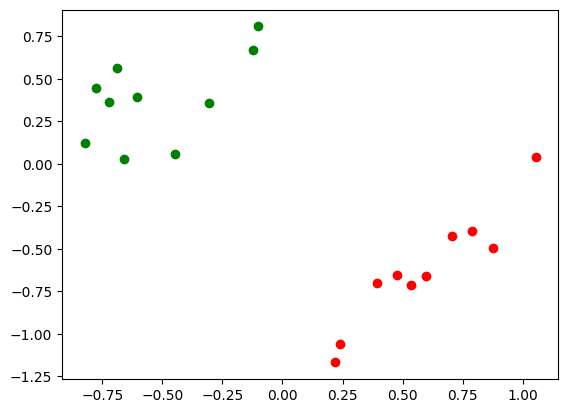

In [ ]:
X = np.array([[-0.60494626,  0.39463717],
       [-0.30378544,  0.35994518],
       [-0.10199207,  0.8077354 ],
       [-0.6891583 ,  0.56531763],
       [-0.82298213,  0.12062865],
       [-0.7219664 ,  0.36234102],
       [-0.7760751 ,  0.44770154],
       [-0.65878356,  0.02599421],
       [-0.44636518,  0.05483197],
       [-0.12357683,  0.67089474],
       [ 0.59597784, -0.6578017 ],
       [ 1.052702  ,  0.03756183],
       [ 0.8736961 , -0.4984176 ],
       [ 0.53515655, -0.71511005],
       [ 0.78909314, -0.39306254],
       [ 0.7054007 , -0.4269686 ],
       [ 0.47644103, -0.65322984],
       [ 0.24000564, -1.0623405 ],
       [ 0.39430314, -0.70325773],
       [ 0.21796265, -1.16941   ]], dtype=np.float32)



Y_ = [0 for i in range(10)] + [1 for i in range(10)]

Y = np.array(Y_, dtype=np.float32)
# show the plot
for i in range(len(X)):
    x,y = X[i]
    label = Y[i]
    if label > 0.5:
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'go')

In [ ]:
X_train = torch.from_numpy(X)
Y_train = torch.from_numpy(Y)
target = Y_train[:, None]
learning_rate = 0.3
params = list(model.parameters())
# criterion = nn.MSELoss()
criterion = nn.BCELoss()


for i in range(100):
    model.zero_grad()

    Y_tmp = model(X_train)
    loss = criterion(Y_tmp, target)
    print(f'i = {i}, loss = {loss}')

    loss.backward()

    # update the gradient
    for f in params:
        f.data.sub_(f.grad.data * learning_rate)

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach() > 0
    return hook

model.relu1.register_forward_hook(getActivation('relu1'))
model.relu2.register_forward_hook(getActivation('relu2'))

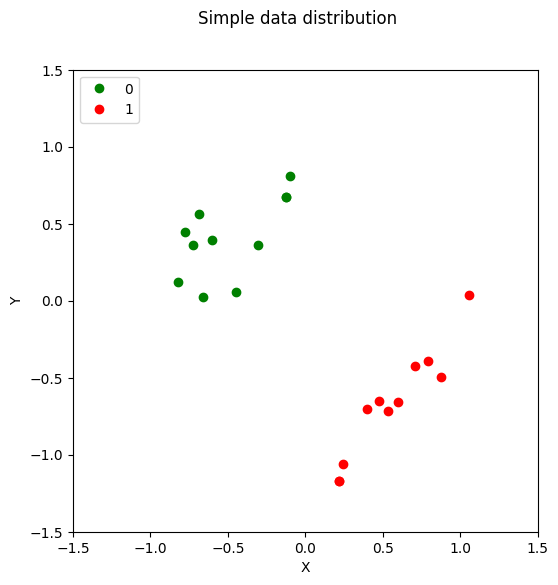

In [ ]:
Y_tmp = model(X_train)


fig = plt.figure(figsize=(6, 6))
for i in range(len(X)):
    x,y = X[i]
    pred = Y_tmp[i][0]
    if pred > 0.5:
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'go')

plt.plot(X[9][0], X[9][1], 'go', label="0")
plt.plot(X[-1][0], X[-1][1], 'ro', label="1")

fig.suptitle('Simple data distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="upper left")
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.show()

In [ ]:
output = model(torch.from_numpy(X[0]))
activation['relu1'][0]

tensor(True)

In [ ]:
Refinement:
 For given area, find adversarial example. Refine that region.